In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt

In [2]:
url = "https://www.ebay.com/b/Microsoft-Xbox-One-S-1TB-Consoles/139971/bn_7112445194?rt=nc&LH_ItemCondition=1000" \
      "&LH_BIN=1&LH_Sold=1"

In [3]:
links = set()
page_number = 1

soup = BeautifulSoup(requests.get(url + "&_pgn=" + str(page_number)).text)
num_results = int(re.search("\s(\d*)\s", soup.find("h2", {"class": "srp-controls__count-heading"}).text).group().strip())
print(num_results)  # strange that this number doesn't match the amount of unique listings publicly available

while True:
    print(page_number, len(links))
    data = requests.get(url + "&_pgn=" + str(page_number)).text
    soup = BeautifulSoup(data)
    new_links = [link["href"] for link in soup.find_all("a", {"class": "s-item__link"})]

    if len(links) >= num_results or page_number == 50:
        break

    for link in new_links: links.add(link)
    page_number += 1

434
1 0
2 48
3 93
4 138
5 177
6 216
7 254
8 281
9 318
10 366
11 369
12 369
13 369
14 369
15 369
16 369
17 369
18 369
19 369
20 369
21 369
22 369
23 369
24 369
25 369
26 369
27 369
28 369
29 369
30 369
31 369
32 369
33 369
34 369
35 369
36 369
37 369
38 369
39 369
40 369
41 369
42 369
43 369
44 369
45 369
46 369
47 369
48 369
49 369
50 369


In [4]:
cleaned_links = []
for i, link in enumerate(links):
    if i % 10 == 0: print(i, "/", len(links))
    soup = BeautifulSoup(requests.get(link).text)
    new_link1 = soup.find("a", {"class": "nodestar-item-card-details__view-link"})
    new_link2 = soup.find("a", {"class": "cvip-item-card-details__view-link"}) 
    if new_link1 is not None and new_link2 is not None:
        print("WTF")
    new_link = new_link1 if new_link2 is None else new_link2
    clean_link = new_link['href'] if new_link is not None else link
    cleaned_links.append(clean_link)

0 / 369
10 / 369
20 / 369
30 / 369
40 / 369
50 / 369
60 / 369
70 / 369
80 / 369
90 / 369
100 / 369
110 / 369
120 / 369
130 / 369
140 / 369
150 / 369
160 / 369
170 / 369
180 / 369
190 / 369
200 / 369
210 / 369
220 / 369
230 / 369
240 / 369
250 / 369
260 / 369
270 / 369
280 / 369
290 / 369
300 / 369
310 / 369
320 / 369
330 / 369
340 / 369
350 / 369
360 / 369


In [5]:
bid_words = {'Accepted', 'Declined', 'Expired', '--'}
def scrape_bid_table(url,page_num=None, iter_num=None):
    response = requests.get(url)
    html_file = response.text

    soup = BeautifulSoup(html_file, 'html.parser') # Parse the HTML as a string
    rows = []
    for tr in soup.find_all('tr'):
        row = []
        tds = tr.find_all('td')
        for i in range(len(tds)):
            row.append(tds[i].text.strip())
        if len(row) == 6 and row[2] not in bid_words: rows.append(row)
    return rows

In [6]:
filter_words = {"bundle", "minecraft", "forza", "sea of thieves", "month", "+", "2K"}

def filter_out(title):
    for word in filter_words:
        if word in title.lower(): 
            return True
    return False

In [8]:
print(len(cleaned_links))

item_titles = "item_titles"
prices = "prices"
current_prices = "current_prices",
shipping_costs = "shipping_costs"
conditions = "conditions"
timestamps = "timestamps"
descriptions = "descriptions"
prod_descriptions = "prod_descriptions"
item_attributes = "item_attributes"

data = {item_titles : [],
        current_prices : [],
        prices : [],
        shipping_costs : [],
        conditions : [],
        timestamps : [],
        descriptions : [],
        prod_descriptions: [],
        item_attributes: [],
       }

strip_end = lambda text, suffix: text if not text.endswith(suffix) or len(suffix) == 0 else text[:-len(suffix)]
strip_begin = lambda text, prefix: text if not text.startswith(prefix) or len(prefix) == 0 else text[len(prefix):]

for i, link in enumerate(cleaned_links):
    if i % 10 == 0: print(i, "/", len(links)) 
    soup = BeautifulSoup(requests.get(link).text)
    
    # TITLE
    title = strip_end(soup.find("title").text, " | eBay").strip()
    
    # CURRENT LIST PRICE
    str_price = soup.select("#prcIsum")

    try:
        current_price = float(strip_end(strip_begin(str_price[0].text.strip(), "US $"), "/ea")) \
        if len(str_price) > 0 and str_price[0] != 'Sold as a special offer' else None
    except:
        continue
    
    # CURRENT SHIPPING COST
    shipping_cost = soup.select("#fshippingCost")[0].text.strip() if len(soup.select("#fshippingCost")) > 0 else 0
    if shipping_cost == "FREE":
        shipping_cost = 0
    if type(shipping_cost) == str:
        shipping_cost = float(strip_end(strip_begin(shipping_cost, "$"), "/ea"))
    
    # ITEM CONDITION
    item_condition = soup.select("vi-itm-cond")
    
    # ITEM DESC
    item_desc = None
    desc_info = soup.select("#desc_ifr")
    if len(desc_info) > 0:
        desc_link = desc_info[0]['src']
        inner_soup = BeautifulSoup(requests.get(desc_link).text)
        item_desc = inner_soup.select("#ds_div")[0].text.strip()

    # ITEM PRODUCT DESCRIPTION
    prod_desc = None
    table = soup.select('#viTabs_0_pd')
    if len(table) > 0 and table[0].find('tbody') is not None:
        table_body = table[0].find('tbody')
        prod_desc = []
        rows = table_body.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            prod_desc.append([ele for ele in cols if ele])
    
    # ITEM ATTRIBUTES
    item_attribute = None
    table = soup.select('#viTabs_0_is')
    if len(table) > 0 and table[0].find('tbody') is not None:
        table_body = table[0].find('tbody')
        item_attribute = []
        rows = table_body.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            item_attribute.append([ele for ele in cols if ele])
        
    # PRICE and TIMESTAMP
    table_link = soup.find("a", {"class": "vi-txt-underline"})
    if table_link is not None:
        table_link = table_link['href']

        rows = scrape_bid_table(table_link)
        for row in rows:
            price_stripped = strip_end(strip_begin(row[2], "US $"), "/ea")
            price = float(price_stripped) \
                if price_stripped != 'Sold as a special offer' and price_stripped != 'Price Not Available' else None
            timestamp = row[4]
            if price == None: break
            if filter_out(title): break
            print(price)
            print(table_link)
            if price > 180: print(price, title)
            data[item_titles].append(title)
            data[prices].append(price)
            data[timestamps].append(timestamp)
            data[current_prices].append(current_price)
            data[shipping_costs].append(shipping_cost)
            data[conditions].append(item_condition)
            data[descriptions].append(item_desc)
            data[prod_descriptions].append(prod_desc)
            data[item_attributes].append(item_attribute)
            

369
0 / 369
10 / 369
20 / 369
30 / 369
40 / 369
50 / 369
150.0
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=153395940109&rt=nc&_trksid=p2047675.l2564
175.0
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=283384310002&rt=nc&_trksid=p2047675.l2564
175.0
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=283384310002&rt=nc&_trksid=p2047675.l2564
60 / 369
70 / 369
259.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=303146643038&rt=nc&_trksid=p2047675.l2564
259.99 Xbox One S 1TB All-Digital Edition Gaming Console 889842443387
80 / 369
90 / 369
193.98
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=163534414969&rt=nc&_trksid=p2047675.l2564
193.98 Xbox One S 1 TB Console 1TB Game System 4K Ultra HD Blu-ray Microsoft Brand New
197.96
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=163534414969&rt=nc&_trksid=p2047675.l2564
197.96 Xbox One S 1 TB Console 1TB Game System 4K Ultra HD Blu-ray Microsoft Brand New
169.0
https://offe

170 / 369
169.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=183720963394&rt=nc&_trksid=p2047675.l2564
169.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=183720963394&rt=nc&_trksid=p2047675.l2564
169.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=183720963394&rt=nc&_trksid=p2047675.l2564
169.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=183720963394&rt=nc&_trksid=p2047675.l2564
168.29
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=183720963394&rt=nc&_trksid=p2047675.l2564
169.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=183720963394&rt=nc&_trksid=p2047675.l2564
169.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=183720963394&rt=nc&_trksid=p2047675.l2564
169.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=183720963394&rt=nc&_trksid=p2047675.l2564
169.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=183720963394&rt=nc&_trksid=p2047675.l2564
169.99
https://off

180 / 369
190 / 369
200 / 369
174.95
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=382814826225&rt=nc&_trksid=p2047675.l2564
174.95
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=382814826225&rt=nc&_trksid=p2047675.l2564
210 / 369
220 / 369
230 / 369
254.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=153286119395&rt=nc&_trksid=p2047675.l2564
254.99 XBOX ONE S - 1 TB - NBA2K19 - Brand New - Factory Sealed! 889842307276
254.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=153286119395&rt=nc&_trksid=p2047675.l2564
254.99 XBOX ONE S - 1 TB - NBA2K19 - Brand New - Factory Sealed! 889842307276
254.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=153286119395&rt=nc&_trksid=p2047675.l2564
254.99 XBOX ONE S - 1 TB - NBA2K19 - Brand New - Factory Sealed! 889842307276
240 / 369
250 / 369
260 / 369
270 / 369
209.99
https://offer.ebay.com/ws/eBayISAPI.dll?ViewBidsLogin&item=183183953127&rt=nc&_trksid=p2047675.l2564
209.99 Xbox One S 

AttributeError: 'NoneType' object has no attribute 'text'

num samples 277
mean 172.705523465704
mode 0    165.0
dtype: float64
median 167.94


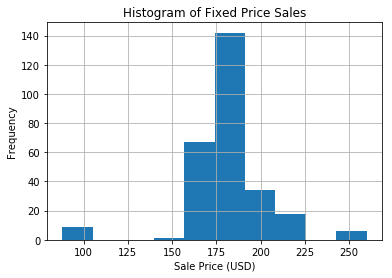

In [10]:
data_frame = pd.DataFrame.from_dict(data)
data_frame["combined_cost"] = data_frame["prices"] + data_frame["shipping_costs"]

print("num samples", len(data_frame))
print("mean", data_frame["prices"].mean())
print("mode", data_frame["prices"].mode())
print("median", data_frame["prices"].median())

fig, ax = plt.subplots()
data_frame.hist(column="combined_cost", ax=ax, bins=10)
plt.title("Histogram of Fixed Price Sales")
plt.ylabel("Frequency")
plt.xlabel("Sale Price (USD)")
fig.savefig('../plots/fixed_price_histogram.png')
data_frame
data_frame.to_csv("../fixed_price_data/fixed_price_data.csv")